# Visualize cloud differences
Trying to better understand the SLF differences between cloud tops and bulk mixed-phase clouds

In [4]:
import sys

# Add common resources
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set up directories based on where the program is being run from

In [5]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    op_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(op_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

obs_dir = 'caliop_slfs/'
output_dir = 'figures/'
case_dir = 'mnth15runs/' # inconsistent label compared to jupy_test
    
# Check that each important directory can be accessed:    
access_paths = os.path.exists(obs_dir) and os.path.exists(output_dir) and os.path.exists(case_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [6]:
data_string = obs_dir + 'MPC_ISO_CALIOP_NorESM.csv'
caliop_processed = os.path.exists(data_string)

#Pick out the right files
file_str = '.dat'
obs_files = os.listdir(obs_dir) # All files in directory
slf_files = [x for x in obs_files if file_str in x]   # files with the CALIOP string
slf_files.sort()

if caliop_processed:
    print('Grabbing data from %s' % data_string)
    all_caliop = pd.read_csv(data_string)

else:
    print('Writing data to %s' % data_string)
    all_caliop = process_caliop(slf_files, obs_dir)
    
    all_caliop.to_csv(path_or_buf = data_string)

all_caliop = all_caliop.set_index('Isotherm')
all_caliop

Grabbing data from caliop_slfs/MPC_ISO_CALIOP_NorESM.csv


,CALIOP_10N-10S,CALIOP_10S-30S,CALIOP_30N-10N,CALIOP_30S-50S,CALIOP_50N-30N,CALIOP_50S-70S,CALIOP_70N-50N,CALIOP_70S-90S,CALIOP_90N-70N,CALIOP Average
Isotherm,,,,,,,,,,
-40,0,0,0,0,0,0,0,0,0,0.000000
-30,4,6,5,7,3,9,5,12,6,5.578054
-20,26,32,28,30,21,37,26,39,31,28.670216
-10,62,64,63,60,56,70,56,61,55,61.357769
0,100,100,100,100,100,100,100,100,100,100.000000


In [7]:
# Load CALIOP data
ct_slf_caliop = xr.open_dataset('caliop_cloudtop/cloudtop_slfs.nc')

In [8]:
bands = {'Global':[-90,90],'70-90N':[70.0,90],'70-90S':[-90,-70.0]}
df = pd.DataFrame()

In [9]:
#df = df.set_index('isotherm')
for i in bands:
    _rng = bands[i]
    
    # Different resolutions, needs different masks. Remember weird mask sign convention: true=not included
    mask1 = np.bitwise_or(ct_slf_caliop['lat']<_rng[0], ct_slf_caliop['lat']>_rng[1])
    
    weight1 = ct_slf_caliop['cell_weight']
    
    slf1 = 100*masked_average(ct_slf_caliop['SLF'], dim=['lat','lon'],weights=weight1, mask=mask1)
    
    stdev1 = 100*np.std(ct_slf_caliop['SLF'].sel(lat=slice(_rng[0],_rng[1])), axis=(0,1))
    
    df['CALIOP %s SLF' % i] = slf1
    df['CALIOP %s StDev' % i] = stdev1

df['isotherm'] = slf1['isotherm']
df = df.set_index('isotherm')

df

,CALIOP Global SLF,CALIOP Global StDev,CALIOP 70-90N SLF,CALIOP 70-90N StDev,CALIOP 70-90S SLF,CALIOP 70-90S StDev
isotherm,,,,,,
-40.0,2.652094,5.807777,2.459061,2.618228,3.890865,3.924511
-35.0,16.110721,16.863898,11.130604,6.531047,29.049865,11.703732
-30.0,48.726922,26.783687,40.034259,11.404743,77.258443,9.443726
-25.0,68.557867,23.702292,67.022117,9.272867,83.958960,18.443270
-20.0,82.848191,18.481084,87.317509,5.492061,88.962112,18.914012
-15.0,89.782925,14.106420,94.698234,3.303115,94.013562,14.513821
-10.0,90.960496,13.894029,97.387566,2.745082,95.451354,14.772262
-5.0,91.791636,14.734814,97.538159,5.369099,96.571141,12.297109
0.0,96.874805,9.863054,98.412958,5.773443,95.408280,18.543827


In [10]:
all_slf = pd.concat([all_caliop, df], axis=1, sort=False).dropna()
all_slf

,CALIOP_10N-10S,CALIOP_10S-30S,CALIOP_30N-10N,CALIOP_30S-50S,CALIOP_50N-30N,CALIOP_50S-70S,CALIOP_70N-50N,CALIOP_70S-90S,CALIOP_90N-70N,CALIOP Average,CALIOP Global SLF,CALIOP Global StDev,CALIOP 70-90N SLF,CALIOP 70-90N StDev,CALIOP 70-90S SLF,CALIOP 70-90S StDev
-40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.652094,5.807777,2.459061,2.618228,3.890865,3.924511
-30.0,4.0,6.0,5.0,7.0,3.0,9.0,5.0,12.0,6.0,5.578054,48.726922,26.783687,40.034259,11.404743,77.258443,9.443726
-20.0,26.0,32.0,28.0,30.0,21.0,37.0,26.0,39.0,31.0,28.670216,82.848191,18.481084,87.317509,5.492061,88.962112,18.914012
-10.0,62.0,64.0,63.0,60.0,56.0,70.0,56.0,61.0,55.0,61.357769,90.960496,13.894029,97.387566,2.745082,95.451354,14.772262
0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.000000,96.874805,9.863054,98.412958,5.773443,95.408280,18.543827


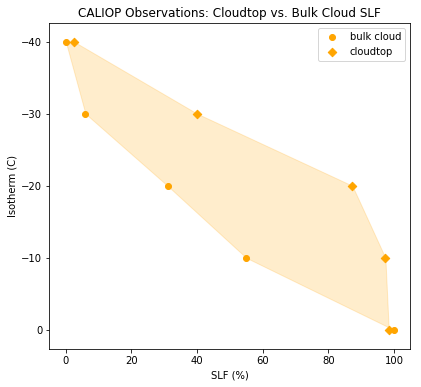

In [11]:
fig1 = plt.figure(figsize=(10,6))#constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=3, nrows=1, figure=fig1)#, hspace=0.4)
f1_ax1 = fig1.add_subplot(spec1[0, :-1])
#f1_ax2 = fig1.add_subplot(spec1[0, -1], sharey=f1_ax1)
#axes = [f1_ax1, f1_ax2]
#plt.setp(f1_ax2.get_yticklabels(), visible=False)

isos = np.array(all_slf.index).reshape(-1,1)

fig1.gca().invert_yaxis()
f1_ax1.set_title('CALIOP Observations: Cloudtop vs. Bulk Cloud SLF'); f1_ax1.set_ylabel('Isotherm (C)'); f1_ax1.set_xlabel('SLF (%)')
#f1_ax2.set_title('NorESM error'); f1_ax2.set_xlabel('SLF Error (%)')

f1_ax1.scatter(all_slf['CALIOP_90N-70N'], all_slf.index, label='bulk cloud', color = 'orange')
f1_ax1.scatter(all_slf['CALIOP 70-90N SLF'], all_slf.index, label='cloudtop', color = 'orange', marker='D')
f1_ax1.fill_betweenx(all_slf.index, all_slf['CALIOP_90N-70N'], all_slf['CALIOP 70-90N SLF'], alpha=0.2, color='orange')

f1_ax1.legend()

In [13]:
filename = 'caliop_cloudtop_vs_bulkcloud.png'
filename
if not os.path.exists(filename):
    fig1.savefig(output_dir + filename,format = 'png', dpi = 200)
    fig1.clf()